<a href="https://colab.research.google.com/github/ranjanguddu/ENDPhase1/blob/main/Session-14/Eng_to_Python_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sacrebleu==1.2.11

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import spacy
import numpy as np
import random
import math
import time
import re
import pandas as pd
from py_tokenizer import *

In [3]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
#!python -m spacy download en
spacy_en = spacy.load('en')
spacy_py = spacy.load('en')


In [5]:
def tokenize_en(text):

  """
  Tokenizes English text from a string into a list of strings
  """
  return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_py(text):
  """
    Tokenizes Python Program from a string into a list of strings
    """
  temp = " ".join(tokenize_python(text))
  return [tok.text for tok in spacy_py.tokenizer(temp)]

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [6]:
fundict ={}
with open('Cleaned_Eng_Python_Data.txt', 'r') as fR:

    #with open('fileWithoutComments.txt', 'w', encoding='utf-8') as fw:
    for i in fR.readlines():

        # print(i, end='')
        # print(type(i))
        if i.startswith('#') and  ('write' in i.lower() or 'python' in i.lower() or \
            'program' in i.lower() or 'function' in i.lower() or 'generate' in i.lower() or \
            'code' in i.lower() or 'given' in i.lower() or 'find' in i.lower() or 'calculate' in i.lower() or\
            'class' in i.lower() or 'define' in i.lower() or 'check' in i.lower() or 'compute' in i.lower() \
            or 'script' in i.lower() or 'calculate' in i.lower()):
            # print(i)
            key = i[1:]
            

            fundict[key]=''
            continue
        else:
            fundict[key]= fundict[key] + i

print(len(fundict))   

3335


In [7]:
src = []
trg = []

src_len = []
trg_len = []

for k,v in fundict.items():
  if len(k)<300 and len(v)<400:
    src.append(k)
    trg.append(v)
    src_len.append(len(k))
    trg_len.append(len(v))
    
print(f'Key_len:{max(src_len)} and Value: {max(trg_len)}, english sentence:{len(src)} and python code:{len(trg)}')


Key_len:257 and Value: 399, english sentence:3071 and python code:3071


In [8]:
src_len=[]
trg_len =[]
for i in range(len(src)):
  src_len.append(len(src[i]))
  trg_len.append(len(trg[i]))

print(max(src_len), max(trg_len))



257 399


In [9]:
raw_data = {'English' : [line for line in src], 'Python': [line for line in trg]}
df = pd.DataFrame(raw_data, columns=["English", "Python"])


In [10]:
from sklearn.model_selection import train_test_split
# create train and validation set 
train, val = train_test_split(df, test_size=0.1)
#train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
#test.to_csv("test.csv", index=False)


In [11]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_py, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)

In [12]:
data_fields = [('English', SRC), ('Python', TRG)]
train,val = TabularDataset.splits(path='./', train='train.csv', validation='val.csv', format='csv', fields=data_fields)

In [13]:
SRC.build_vocab(train, val)
TRG.build_vocab(train, val)

In [14]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of validation examples: {len(val.examples)}")

Number of training examples: 2764
Number of validation examples: 309


In [15]:
print(vars(train.examples[1]))
print(vars(val.examples[1]))

{'English': [' ', 'write', 'a', 'python', 'function', 'to', 'extract', 'odd', 'length', 'words', 'in', 'string'], 'Python': ['def', 'findoddlenthwords', '(', 'test_str', ')', ':', 'NEW_LINE', 'INDENT', 'res', '=', '[', ']', 'NEW_LINE', 'for', 'ele', 'in', 'test_str', '.', 'split', '(', ')', ':', 'NEW_LINE', 'INDENT', 'if', 'len', '(', 'ele', ')', '%', '2', ':', 'NEW_LINE', 'INDENT', 'res', '.', 'append', '(', 'ele', ')', 'NEW_LINE', 'DEDENT', 'DEDENT', 'return', 'res', 'NEW_LINE', 'DEDENT']}
{'English': [' ', 'write', 'a', 'python', 'program', 'to', 'typecast', 'given', 'input', 'to', 'float'], 'Python': ['num', '=', 'float', '(', 'input', '(', '"', 'Input', '▁', 'a', '▁', 'value', ':', '▁', '"', ')', ')', 'NEW_LINE', 'print', '(', 'num', ')', 'NEW_LINE']}


In [16]:
n=7
print(' '.join([str(elem) for elem in vars(train.examples[n])['English'][1:]]))
print(detokenize_python(vars(train.examples[n])['Python']))
print(' '.join([str(elem) for elem in vars(val.examples[n])['English'][1:]]))
#convert_format(vars(val.examples[1])['Python'])
print(detokenize_python(vars(val.examples[n])['Python']))


write a python program to input a number n and print an inverted star pattern of the desired size .
n = int ( input ( "Enter number of rows: " ) )
for i in range ( n , 0 , - 1 ) :
    print ( ( n - i ) * ' ' + i * '*' )

write a program to write a string in a file
filename = 'file1.txt'
string = "programming in \n python"
f1 = open ( filename , 'w' )
f1.write ( string )
f1.close ( )



In [17]:
# print(' '.join([str(elem) for elem in vars(train.examples[1])['English']]))
# print(' '.join([str(elem) for elem in vars(train.examples[1])['Python']]))
# print(' '.join([str(elem) for elem in vars(val.examples[1])['English']]))

# print(' '.join([str(elem) for elem in vars(val.examples[1])['Python']]))



In [18]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 1957
Unique tokens in target (en) vocabulary: 4514


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
BATCH_SIZE = 64

train_iterator, valid_iterator = BucketIterator.splits((train, val),sort_key=lambda x: len(x.Python),\
                                                       sort_within_batch=False, batch_size = BATCH_SIZE, \
                                                       device = device)

In [21]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 260):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        #print(f'batch_size:{batch_size}')
        src_len = src.shape[1]
        #print(f'src_len:{src_len}')

        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            
            src = layer(src, src_mask)
            

        #print('src layers created')  
        #src = [batch size, src len, hid dim]

        #print('going to return src') 
        return src

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [23]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [24]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [25]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 400):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        #print(f'target length:{trg_len}')
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

10000
11000
11100
11100
11100

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
        
        #print(f'trg_pad_mask:{trg_pad_mask.is_cuda}, and trg_sub_mask: {trg_sub_mask.is_cuda} ')
        trg_mask = trg_pad_mask & trg_sub_mask

        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        #print(f'src_mask received')
        trg_mask = self.make_trg_mask(trg)
        #print(f'trg_mask received')
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #print('enc_src done')
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 512
ENC_LAYERS = 6
DEC_LAYERS = 6
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [29]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,510,050 trainable parameters


In [31]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [32]:
model.apply(initialize_weights);

In [33]:
LEARNING_RATE = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [34]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [35]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    
    for i, batch in enumerate(iterator):
        
        
        src = batch.English
        #print(f'src:{src}')
        trg = batch.Python
        #print(f'trg:{trg}')
        
        optimizer.zero_grad()
        #print(f'optimizer phase done')
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [36]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.English
            trg = batch.Python

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Eng-to-Python-model.pt')
        
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 23s
	Train Loss: 6.094 | Train PPL: 443.409
	 Val. Loss: 4.983 |  Val. PPL: 145.953
Epoch: 02 | Time: 0m 23s
	Train Loss: 4.732 | Train PPL: 113.519
	 Val. Loss: 4.357 |  Val. PPL:  78.051
Epoch: 03 | Time: 0m 25s
	Train Loss: 3.885 | Train PPL:  48.672
	 Val. Loss: 3.452 |  Val. PPL:  31.574
Epoch: 04 | Time: 0m 25s
	Train Loss: 3.290 | Train PPL:  26.849
	 Val. Loss: 3.073 |  Val. PPL:  21.600
Epoch: 05 | Time: 0m 25s
	Train Loss: 2.972 | Train PPL:  19.522
	 Val. Loss: 2.846 |  Val. PPL:  17.217
Epoch: 06 | Time: 0m 24s
	Train Loss: 2.745 | Train PPL:  15.558
	 Val. Loss: 2.691 |  Val. PPL:  14.749
Epoch: 07 | Time: 0m 25s
	Train Loss: 2.575 | Train PPL:  13.126
	 Val. Loss: 2.560 |  Val. PPL:  12.937
Epoch: 08 | Time: 0m 24s
	Train Loss: 2.432 | Train PPL:  11.385
	 Val. Loss: 2.447 |  Val. PPL:  11.557
Epoch: 09 | Time: 0m 24s
	Train Loss: 2.315 | Train PPL:  10.124
	 Val. Loss: 2.373 |  Val. PPL:  10.732
Epoch: 10 | Time: 0m 25s
	Train Loss: 2.215 | Train PPL

In [39]:
model.load_state_dict(torch.load('Eng-to-Python-model.pt'))


<All keys matched successfully>

In [40]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 500):
    
    model.eval()
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
        #tokens = nlp(sentence.lower()).split()
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [41]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [42]:
translation, attention = translate_sentence( 'program to add two numbers', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

num1 = 1.5
num2 = 6.3
sum = num1 + num2
print ( f 'Sum: {sum}' )


In [43]:
translation, attention = translate_sentence( 'python function to add two user provided numbers and return the sum', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

def dot_product ( a , b ) :
    return sum ( b + b )
    


In [44]:
translation, attention = translate_sentence( 'python program to find and print the largest among three numbers', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

num1 = 10
num2 = 12
num3 = 12
if ( num1 > = num2 ) and ( num2 > = num3 ) :
    largest = num1
else :
    largest = num3
print ( "The largest of largest are" , largest )


In [48]:
translation, attention = translate_sentence( 'write a program to find and print the smallest among three numbers', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

def largest ( x , y ) :
    if x > y :
        return x
    elif x > y :
        return x
    else :
        smaller = x
print ( "The largest of" )
print ( num1 , largest )


In [49]:
translation, attention = translate_sentence( 'program to print the multiplication table of a given number', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

num = int ( input ( "Enter a number: " ) )
for i in range ( 1 , 11 ) :
    print ( num , ',' x ',i,i,' = ' , i , i )
    


In [50]:
translation, attention = translate_sentence( 'Write a program to filter the numbers in a list which are divisible by a given number', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

my_list = [ 11 , 45 , 74 , 74 , 74 , 74 , 74 , 74 , 44 , 721 , 721 , 721 ]
result = list ( filter ( lambda x : ( x % my_list = = 0 ) , my_list ) )
print ( f "Numbers divisible by {result} {result} are {result} is {result}" )


In [51]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_py, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)

data_fields = [('English', SRC), ('Python', TRG)]
train,val = TabularDataset.splits(path='./', train='train.csv', validation='val.csv', format='csv', fields=data_fields)

SRC.build_vocab(train, val)
TRG.build_vocab(train, val)

In [52]:
for i in range(90,100):
  src = vars(train.examples[i])['English']
  print(f'Example {i}:\n')
  print(' '.join([str(elem) for elem in src]))
  # print('\nActual Python Code')
  # trg = vars(train.examples[i])['Python']
  # print(detokenize_python(trg))
  print('\nPredicted Python Code')
  translation, attention = translate_sentence(src, SRC, TRG, model, device)
  print(detokenize_python(translation[:-2]))


Example 90:

  write a python function to return an iterator over the last n items

Predicted Python Code
def deque ( iterable , n ) :
    return tuple ( iterable )
    
Example 91:

  write a   program to find the sum of natural numbers

Predicted Python Code
num = 16
if num < 0 :
    print ( "Enter a positive number" )
else :
    sum = 0
    while ( num > 0 ) :
        sum + = num
        num -= 1
    print ( "The sum is" , sum )
    
Example 92:

  write a python program to print a random number between 0 and 1

Predicted Python Code
import random
print ( random.sample ( range ( 1 , 10 ) ) )
Example 93:

  write python program for illustration of values ( ) method of dictionary

Predicted Python Code
test_dict = { 'Gfg' : 3 , 'is' : 8 , 'best' : 8 }
print ( "The original dictionary : " + str ( test_dict ) )
res = dict ( zip ( test_dict.values ( ) ) )
print ( "The dictionary of dictionary : " + str ( res ) )
Example 94:

  write a python function to check whether a given year is a le

In [57]:
for i in range(90,100):
  src = vars(val.examples[i])['English'][1:]
  #print(f'Example {i}:\n')
  print(' '.join([str(elem) for elem in src]))
  # print('\nActual Python Code')
  # trg = vars(train.examples[i])['Python']
  # print(detokenize_python(trg))
  #print('\nPredicted Python Code')
  translation, attention = translate_sentence(src, SRC, TRG, model, device)
  
  print(detokenize_python(translation[:-2]))


write a python function to return the length of an array plus 27
def arr ( arr ) :
    arr = [ ]
    for i in range ( n ) :
        if arr [ i ] > arr [ i ] :
            arr [ i ] = arr [ i ]
    return arr
    
python code to attache ggogle drive in colab
import sys
print ( "Original name is " , sys.replace ( ' ' ) )
write a python program to calculate the lcm and hcf of two given numbers
def lcm ( num1 , num2 ) :
    lcm = num1 , num2
    if num1 > num2 and ( num2 % num2 = = 0 ) :
        lcm = lcm
    else :
        lcm = lcm.multiple
    return lcm
num1 = 54
num2 = 54
print ( "The LCM is" , compute_lcm ( num1 , num2 ) )
write a python program to flatten a shallow list
list1 = [ [ 1 , 2 ] , [ 3 ] , [ 5 , 6 ] ]
flatten = [ ]
flatten = [ i ]
print ( flatten ( flatten ) )
write a python program to create one - hot encodings of a categorical variable
import math
def binary_to_gray ( n ) :
    return math.sqrt ( n )
    
write a python function to count how many times the predicate is t

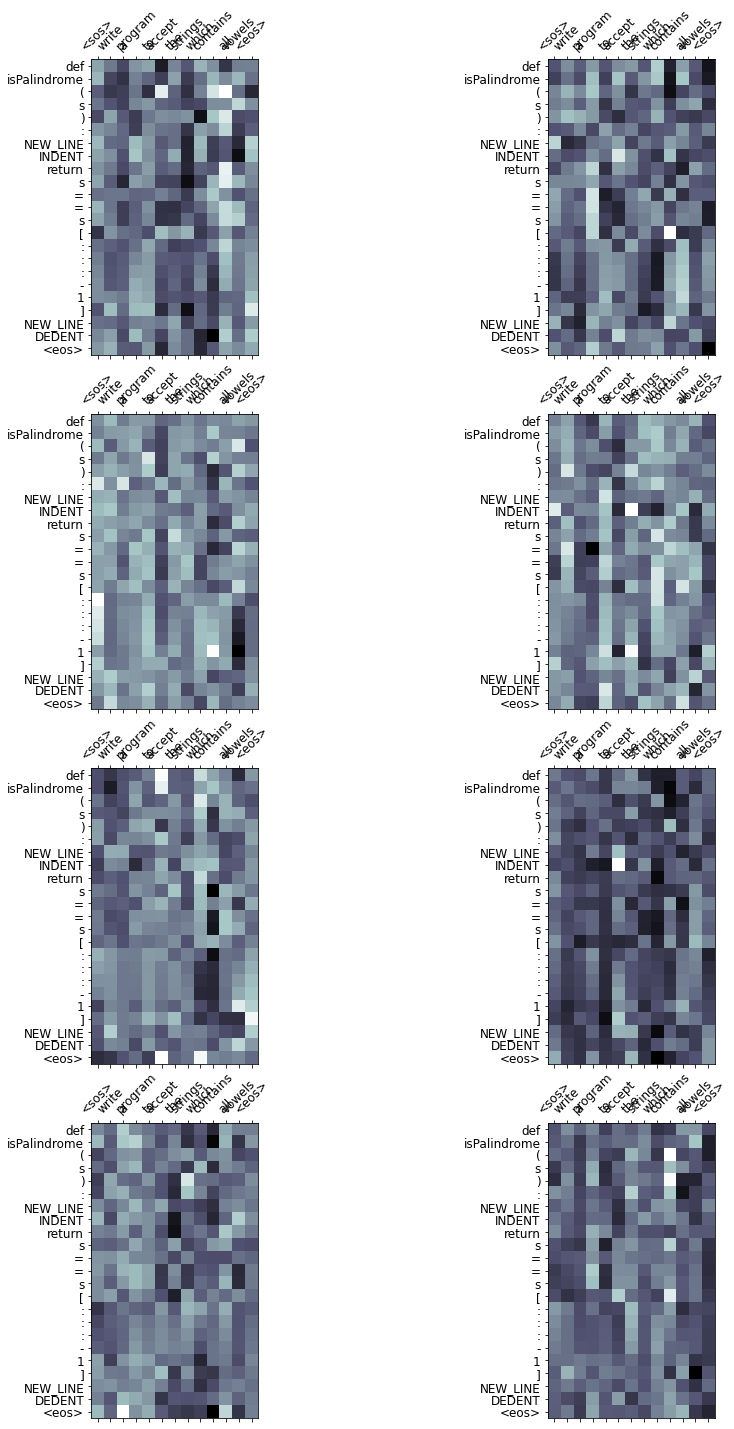

In [58]:
display_attention(src, translation, attention)


In [59]:
translation, attention = translate_sentence('given a list slice it into a 3 equal chunks and revert each list in python', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

sampleList = [ 11 , 45 , 45 , 45 , 45 , 89 ]
length = len ( sampleList )
start = chunkSize
start = chunkSize
for i in range ( 1 , 1 , 11 ) :
    if ( i ! = 0 ) :
        indexes = chunkSize
    else :
        end + = chunkSize
print ( "After reversing length length " , chunkSize )


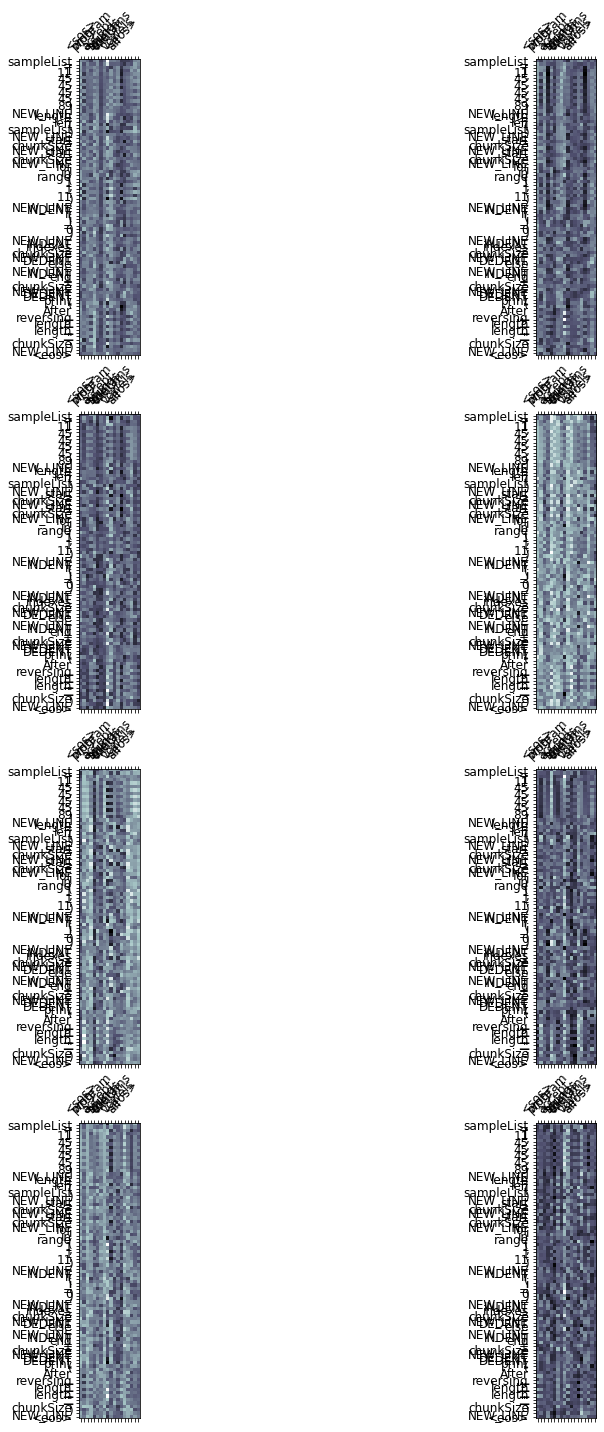

In [60]:
display_attention(src, translation, attention)


In [61]:
translation, attention = translate_sentence( 'program to add two numbers', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

num1 = 1.5
num2 = 6.3
sum = num1 + num2
print ( f 'Sum: {sum}' )


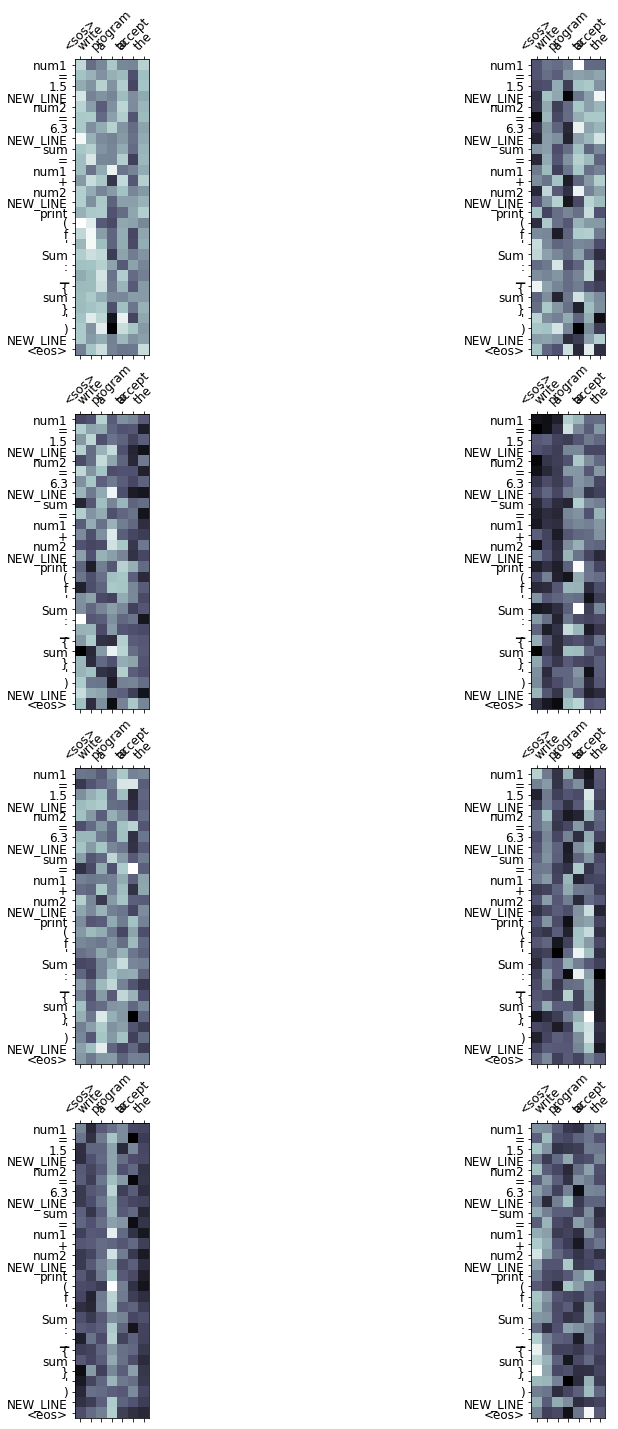

In [62]:
display_attention(src, translation, attention)


In [ ]:
translation, attention = translate_sentence('python program to calculate the area of a circle', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

def findArea ( r ) :
    PI = float ( r * r )
    return area
    


In [ ]:
translation, attention = translate_sentence('python program to demonstrate Least Frequent Character in String', SRC, TRG, model, device)
print(detokenize_python(translation))

test_str = "Gfg"
print ( "The original string is : " + test_str )
all_freq = { }
for i in test_str :
    if i in all_freq :
        all_freq [ i ] + = 1
    else :
        all_freq [ i ] = 1
res = all_freq [ i ] = 1
print ( "The maximum of all characters in is : " + str ( res ) )
<eos>


In [ ]:
translation, attention = translate_sentence('write a program extract least frequency element', SRC, TRG, model, device)
print(detokenize_python(translation))

test_str = 'Gfg is best best best best for best best best geeks'
print ( "The original is : " + test_str )
res = { }
for key , key in test_str :
    if key = test_str.isdigit ( ) :
        res.isdigit ( )
    else :
        res = True
    res = res.append ( key )
print ( res )
<eos>


In [65]:
translation, attention = translate_sentence( 'write a python program to find the smallest multiple of the first n numbers', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))

def smallest_multiple ( n ) :
    if ( n < = 2 ) :
        return n
    n = n * 2
    factors = [ ]
    while n < n :
        if n < = n :
            factors.append ( n )
            a + = 1
        return factors
    


In [66]:
translation, attention = translate_sentence( 'python function that takes two lists as input and returns a zipped list of corresponding elements', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))


def zip_list ( list1 , list2 ) :
    return list ( zip ( list1 , list2 ) )
    


In [67]:
translation, attention = translate_sentence( 'Write a program to to print the contents of a given file', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))


fname = input ( "Enter file name: " )
with open ( fname , 'r' ) as f :
    print ( f.read ( ) )
    


In [69]:
translation, attention = translate_sentence( 'python program to print the unique elements in a list', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))


my_list = [ 1 , 2 , 3 , 4 , 5 , 2 , 4 , 5 , 6 , 7 , 8 , 10 ]
print ( f 'List: {list}' )


In [73]:
translation, attention = translate_sentence( 'python function to find the area of rectangle', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))


def rectangle_area ( l , b ) :
    return l * b
    


In [76]:
translation, attention = translate_sentence( 'program to calculate and print the volume of a cylender', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))


def volume ( radius , h ) :
    volume = 3.14 * * 3
    return volume
    


In [77]:
translation, attention = translate_sentence( 'function to calculate simple interest, given p, r, t', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))


def compound_interest ( p , r , r , r ) :
    interest = ( p * t / 100 ) / 100
    return interest
    


In [78]:
translation, attention = translate_sentence( 'Write a lambda function to multiply two numbers', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))


num1 = 10
num2 = lambda a : a * b
print ( f 'Sum: {result}' )


In [79]:
translation, attention = translate_sentence( 'python program to Get the maximum and minimum value in a dictionary', SRC, TRG, model, device)
print(detokenize_python(translation[:-2]))


thisdict = { "brand" : "Ford" , "model" : "Mustang" , "year" : 1964 }
print ( f "Length of Dictionary:{len(thisdict)}" )
